In [1]:
import numpy as np
from astropy.io import fits
import os
import glob as glob
import pandas as pd
import dawis as d
import matplotlib.pyplot as plt
from matplotlib import colors, colorbar
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
import matplotlib.image as mpimg
from astropy.visualization import *
from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.offsetbox import AnchoredText
from scipy.ndimage import gaussian_filter
from scipy.ndimage import zoom
import pyregion as pyr
import cmasher
import matplotlib as mpl
import pyregion as pyr
from photutils.isophote import EllipseGeometry, Ellipse, build_ellipse_model
from photutils.aperture import EllipticalAperture
from photutils.segmentation import SourceFinder
import scipy.optimize as opt

In [2]:
# Paths, lists & variables
path_data = '/home/aellien/JWST/data/'
path_scripts = '/home/aellien/JWST/JWST_scripts'
path_wavelets = '/home/aellien/JWST/wavelets/out21/'
path_plots = '/home/aellien/JWST/plots'
path_analysis = '/home/ellien/JWST/analysis'

In [51]:
# concat dataframes
init = True
for nf in glob.glob( os.path.join(path_wavelets, '*fICL.txt')):
    if init:
        tot_df = pd.read_csv(nf, sep = ' ')
        init = False
    else:
        df = pd.read_csv(nf, sep = ' ')
        tot_df = pd.concat([ tot_df, df], axis = 0)
tot_df = tot_df.sort_values(by = 'name')

In [52]:
tot_df.keys()

Index(['Unnamed: 0', 'name', 'lvl_sep', 'size_sep', 'F_ICLBCG_m',
       'F_ICLBCG_low', 'F_ICLBCG_up', 'F_gal_m', 'F_gal_low', 'F_gal_up',
       'f_ICLBCG_m', 'f_ICLBCG_low', 'f_ICLBCG_up', 'F_128kpc_icl_m',
       'F_128kpc_icl_low', 'F_128kpc_icl_up', 'F_200kpc_icl_m',
       'F_200kpc_icl_low', 'F_200kpc_icl_up', 'F_400kpc_icl_m',
       'F_400kpc_icl_low', 'F_400kpc_icl_up', 'F_50_150kpc_icl_m',
       'F_50_150kpc_icl_low', 'F_50_150kpc_icl_up', 'F_128kpc_gal_m',
       'F_128kpc_gal_low', 'F_128kpc_gal_up', 'F_200kpc_gal_m',
       'F_200kpc_gal_low', 'F_200kpc_gal_up', 'F_400kpc_gal_m',
       'F_400kpc_gal_low', 'F_400kpc_gal_up', 'F_50_150kpc_gal_m',
       'F_50_150kpc_gal_low', 'F_50_150kpc_gal_up'],
      dtype='object')

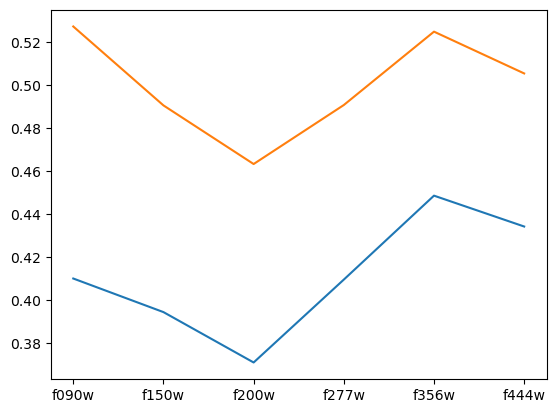

In [53]:
plt.figure()
filtl = [ name.split('_')[1] for name in tot_df['name']]
plt.plot(filtl, tot_df['f_ICLBCG_m'])

f50_150 = tot_df['F_50_150kpc_icl_m'] / ( tot_df['F_50_150kpc_gal_m'] + tot_df['F_50_150kpc_icl_m'])
plt.plot(filtl, f50_150)
plt.show()

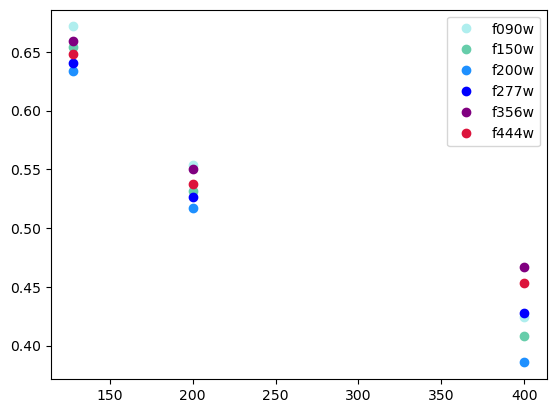

In [71]:
plt.figure()
rl = [128, 200, 400]
colors = [ 'paleturquoise', 'mediumaquamarine', 'dodgerblue', 'blue', 'purple', 'crimson']
for r in rl:
    fICL =  tot_df['F_%03dkpc_icl_m'%r] / ( (tot_df['F_%03dkpc_icl_m'%r] + tot_df['F_%03dkpc_gal_m'%r]))
    for f, filt, color in zip(fICL, filtl, colors):
        if r == 128:
            plt.plot(r, f, 'o', color = color, label = filt)
        else:
            plt.plot(r, f, 'o', color = color)
plt.legend()
plt.show()

In [64]:
def Gaussian_2d(coo, A, mu_x, mu_y, sigma_x, sigma_y):
    x, y = coo
    G= A*np.exp(-(x-mu_x)**2/(2*sigma_x**2) - (y-mu_y)**2/(2*sigma_y**2) )
    return np.ravel(G)

def rebin(im, xbin = 2, ybin = 2, type = 'SUM'):

    xedge = np.shape(im)[0]%xbin
    yedge = np.shape(im)[1]%ybin
    im = im[xedge:,yedge:]
    binim = np.reshape(im,(int(np.shape(im)[0]/xbin),xbin,int(np.shape(im)[1]/ybin),ybin))

    if type == 'MEAN':
        binim = np.mean(binim,axis=3)
        binim = np.mean(binim,axis=1)
    elif type == 'SUM':
        binim = np.sum(binim,axis=3)
        binim = np.sum(binim,axis=1)

    return binim

/home/aellien/JWST/wavelets/out21/jw02736001001_f090w_bkg_rot_crop_warp_nobkg2_synth.bcgwavsizesepmask_005_080.fits
0.192572662991305 9.187813254552037e-05
(2045, 2045) (2045, 2045)


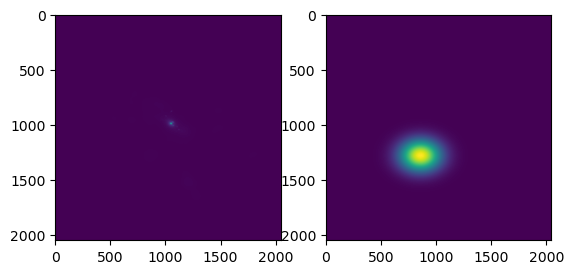

/home/aellien/JWST/wavelets/out21/jw02736001001_f150w_bkg_rot_crop_warp_nobkg2_synth.bcgwavsizesepmask_005_080.fits
0.192572662991305 9.187813254552037e-05
(2045, 2045) (2045, 2045)


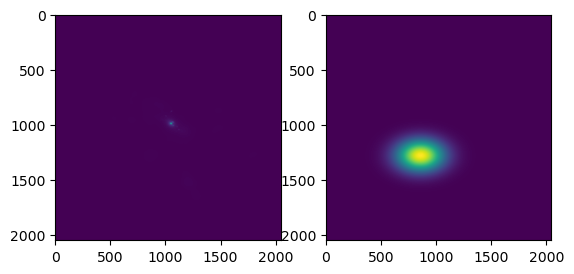

/home/aellien/JWST/wavelets/out21/jw02736001001_f200w_bkg_rot_crop_warp_nobkg2_synth.bcgwavsizesepmask_005_080.fits
0.192572662991305 9.187813254552037e-05
(2045, 2045) (2045, 2045)


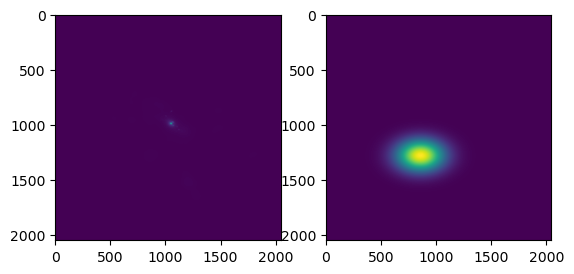

/home/aellien/JWST/wavelets/out21/jw02736001001_f277w_bkg_rot_crop_input_synth.bcgwavsizesepmask_005_080.fits
0.192572662991305 9.187813254552037e-05
(2045, 2045) (2045, 2045)


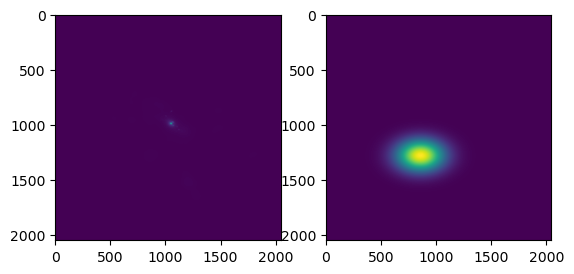

/home/aellien/JWST/wavelets/out21/jw02736001001_f356w_bkg_rot_crop_input_synth.bcgwavsizesepmask_005_080.fits
0.192572662991305 9.187813254552037e-05
(2045, 2045) (2045, 2045)


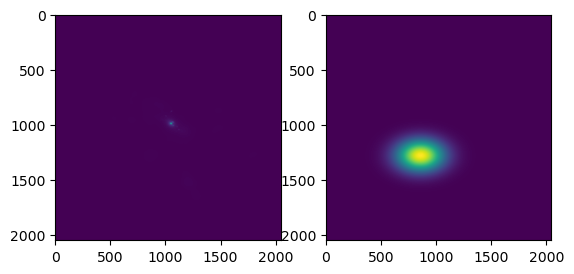

/home/aellien/JWST/wavelets/out21/jw02736001001_f444w_bkg_rot_crop_input_synth.bcgwavsizesepmask_005_080.fits
0.192572662991305 9.187813254552037e-05
(2045, 2045) (2045, 2045)


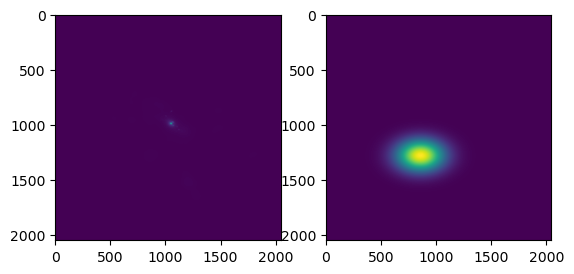

In [65]:
nfdl = [ {'nf':'jw02736001001_f356w_bkg_rot_crop_input.fits', 'filt':'f356w', 'chan':'long', 'pix_scale':0.063, 'pixar_sr':9.31E-14, 'phot_corr':0.163, 'n_levels':10 }, \
        {'nf':'jw02736001001_f444w_bkg_rot_crop_input.fits', 'filt':'f444w', 'chan':'long', 'pix_scale':0.063, 'pixar_sr':9.31E-14, 'phot_corr':0.162, 'n_levels':10 }, \
        {'nf':'jw02736001001_f277w_bkg_rot_crop_input.fits', 'filt':'f277w', 'chan':'long', 'pix_scale':0.063, 'pixar_sr':9.31E-14, 'phot_corr':0.223, 'n_levels':10 }, \
        {'nf':'jw02736001001_f090w_bkg_rot_crop_warp_nobkg2.fits', 'filt':'f090w', 'chan':'short', 'pix_scale':0.031, 'phot_corr':-0.174, 'pixar_sr':2.29E-14, 'n_levels':10 }, \
        {'nf':'jw02736001001_f150w_bkg_rot_crop_warp_nobkg2.fits', 'filt':'f150w', 'chan':'short', 'pix_scale':0.031, 'phot_corr':-0.047, 'pixar_sr':2.31E-14, 'n_levels':10 }, \
        {'nf':'jw02736001001_f200w_bkg_rot_crop_warp_nobkg2.fits', 'filt':'f200w', 'chan':'short', 'pix_scale':0.031, 'phot_corr':-0.114, 'pixar_sr':2.29E-14, 'n_levels':10 } ]
filterl = [ 'f090w', 'f150w', 'f200w', 'f277w', 'f356w', 'f444w' ]
binning_factor = 4151 / 2045 # size short / size long
binf = 2
oiml = []
reciml = []
xbox, ybox = 1280, 855
sbox = 450
xmax, ymax, xmin, ymin = int(xbox + sbox /2.),\
                         int(ybox + sbox /2.),\
                         int(xbox - sbox /2.),\
                         int(ybox - sbox /2.)
for i, filt in enumerate(filterl):
    for nfd in nfdl:
        if nfd['filt'] == filt:
            
            nfp = os.path.join(path_data, nfd['nf'])
            hdu = fits.open(nfp)
            oim = hdu[0].data
            oiml.append(oim)
            
            nfp = os.path.join(path_wavelets, nfd['nf'][:-5] + '_synth.bcgwavsizesepmask_005_080.fits')
            print(nfp)
            hdu = fits.open(nfp)
            recim = hdu[1].data[:2045, :2045]
            
            #finder = SourceFinder(npixels=10, progress_bar=False)
            #segment_map = finder(recim, 0)
            #print(segment_map.data[xbox, ybox])
            #sup[segment_map.data != segment_map.data[xbox, ybox]] = 0.
            
            star_box = sup[ xmin:xmax, ymin:ymax]
            x = np.linspace(0, 2045, 2045)
            y = np.linspace(0, 2045, 2045)
            x,y = np.meshgrid(x, y)

            print(star_box.max(), star_box.min())
            if filt in ['f277w', 'f356w', 'f444w' ]:
                fitted = Gaussian_2d((x,y), 0.008, 855, 1280, 150, 100).reshape(2045,2045)
            if filt == 'f090w':
                fitted = Gaussian_2d((x,y), 0.03, 855, 1280, 130, 100).reshape(2045,2045)
            if filt in ['f150w', 'f200w']:
                fitted = Gaussian_2d((x,y), 0.04, 855, 1280, 150, 100).reshape(2045,2045)

            print(np.shape(fitted), np.shape(recim))
            recim -= fitted
            #recim[ recim < 0] = 0.
            
            #p0 = np.array([0.05, sbox / 2.,sbox /2.,50, 50])
            #popt, pcov = opt.curve_fit(Gaussian_2d,(x,y), np.ravel(star_box), )
            #print(popt)
            #fitted = Gaussian_2d((x,y), *popt).reshape(sbox,sbox)
            
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(sup)
            ax[1].imshow(fitted)
            plt.show()
            
            r = pyr.open(os.path.join(path_data, "star_flags_polygon_pix_long.reg")).as_imagecoord(hdu[1].header)
            m = r.get_mask(hdu = hdu[1])[:2045, :2045]
            recim[m] = np.min(recim)
            recim = rebin(recim, 10, 10, 'SUM')

            reciml.append(recim)

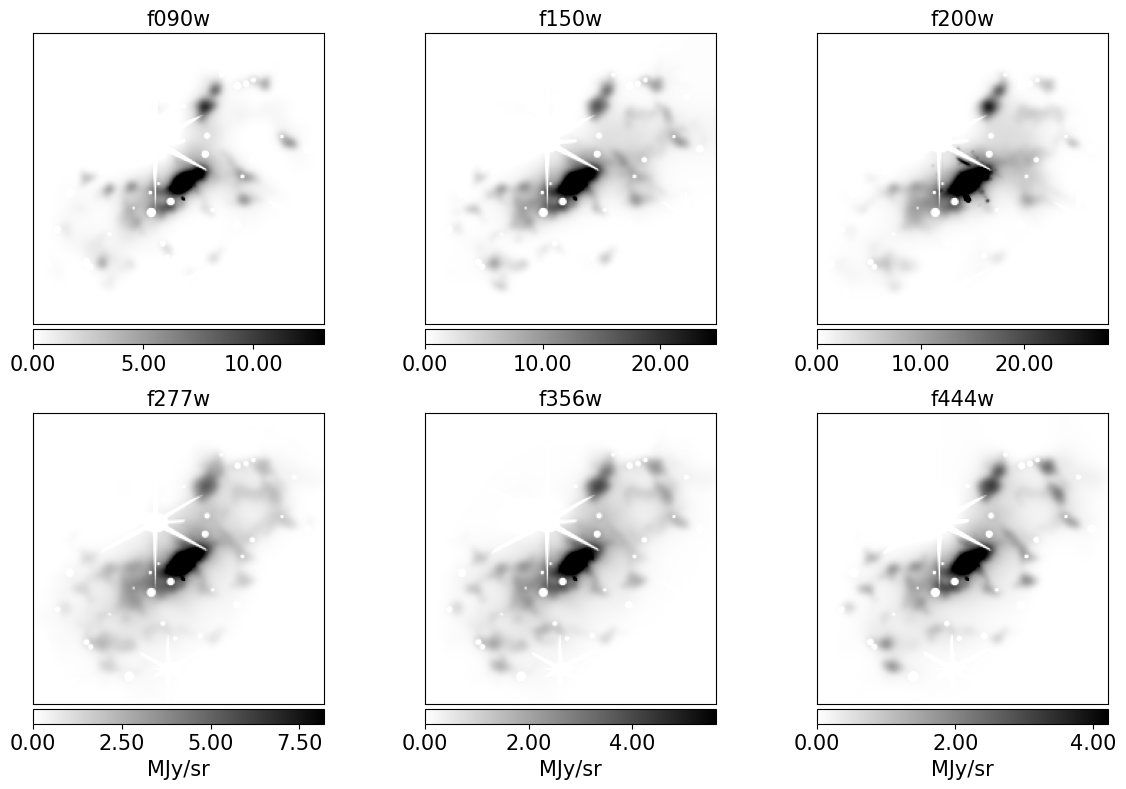

In [66]:
fig, ax = plt.subplots(2, 3, figsize = (12,8))
cmap = 'gray_r'
#print(np.shape(reciml))
k = 0
l = -1
for i, filt in enumerate(filterl):
    l = l + 1
    if l > 2:
        l = 0
        k += 1
    norm = ImageNormalize( rebin(oiml[i], 10, 10), vmin = 0., interval = ZScaleInterval(), stretch = LinearStretch())
    poim = ax[k][l].imshow( reciml[i], norm = norm, cmap = cmap, origin = 'lower')
    ax[k][l].get_xaxis().set_ticks([])
    ax[k][l].get_yaxis().set_ticks([])
    divider = make_axes_locatable(ax[k][l])
    cax = divider.append_axes("bottom", size="5%", pad=0.05)
    caxre = fig.colorbar( poim, cax = cax, \
                                cmap = cmap, \
                                orientation = 'horizontal', \
                                format = '%1.2f',\
                                pad = 0,\
                                shrink = 1.0,\
                                ticklocation = 'bottom' )
    caxre.ax.tick_params(labelsize = 15)
    if k == 1:
        cax.set_xlabel('MJy/sr', fontsize = 15)
    ax[k][l].set_title('%s'%filt, fontsize = 15)
plt.tight_layout()
#plt.subplots_adjust( left=0.05, bottom=0.05, right=0.98, top=0.98, wspace=0.03, hspace=0.1)
plt.savefig(os.path.join(path_plots, 'plot_example_recim_all_filter_maps_out21.pdf'), format = 'pdf', dpi = 500)
plt.show()



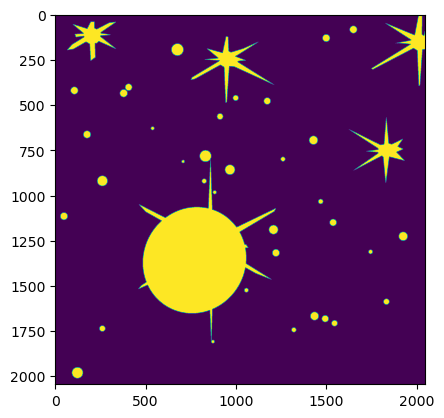

In [59]:
rstar = pyr.open(os.path.join(path_data, 'icl_flags_ellipse_pix_long_test.reg'))
mstar = rstar.get_mask(hdu = hdu[1])
